In [1]:
import paco.processing.paco as p
import paco.processing.fullpaco as f_paco
import paco.processing.fastpaco as fastPACO

from paco.util.util import *
import cv2 as cv2
from astropy.convolution import convolve, Gaussian2DKernel, AiryDisk2DKernel
from astropy.modeling.models import Gaussian2D
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm 


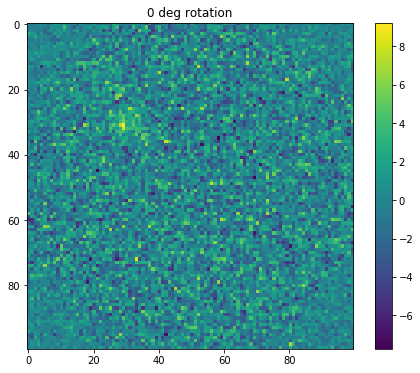

In [2]:

angles = np.linspace(0,125,5)#np.array([0, 30, 45, 60, 90])
p0 = (30,30)
sigma = 1 # gaussian noise

mean = 0

images = [np.reshape(np.random.normal(mean, sigma, 10000), (100,100)) for j in range(len(angles))]
X,Y = np.meshgrid(np.arange(-50, 50),np.arange(-50, 50))
xx, yy = np.meshgrid(np.arange(-30, 70),np.arange(-30, 70))
s = gaussian2d(xx,yy,1, 3)

#images_signal = [i + s for i in images]
rot_noise = np.array([rotateImage(images[j], angles[j]) for j in range(len(images))])
rot_sigs = np.array([rotateImage(s, angles[j]) for j in range(len(images))])
rot_images = np.array([rot_noise[j] + rot_sigs[j] for j in range(len(images))])

sum_ims = np.sum([rotateImage(rot_images[j], -1.0*angles[j]) for j in range(len(images))], axis = 0)
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,6))
im = ax.imshow(sum_ims)
ax.set_title("0 deg rotation")
fig.colorbar(im,ax = ax)




In [3]:
'''
angles = np.linspace(0,110,8)
p0 = (30,30)
sigma = 0.5 # gaussian noise

mean = 0
oa = AiryDisk2DKernel(1)
ps = AiryDisk2DKernel(15)
images = [np.reshape(np.random.normal(mean, sigma, 10000), (100,100)) for j in range(len(angles))]
xx, yy = np.meshgrid(np.arange(-30, 70),np.arange(-30, 70))
xf,yf = np.meshgrid(np.arange(-50, 50),np.arange(-50, 50))
#RHO, THETA = grid_cart_to_pol(xf,yf)

off_axis = convolve(gaussian2d(xx,yy,5.0, 1),oa)
psf = convolve(gaussian2d(xf,yf,1000,1),ps)
#Vortex = np.exp(1j*2*THETA) # vortex phase mask of charge 2 (charge is the # of phase jumps)


#plot_im_LP(np.abs(LP), apRad, 1.5) # Plot lyot plane

images_signal = [i + off_axis + psf for i in images]
rot_images = np.array([rotateImage(images_signal[j], angles[j]) for j in range(len(images_signal))])
#LP = [np.real(np.fft.fft2(im*Vortex)) for im in rot_images]

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,6))
ax.imshow(rot_images[0])
ax.set_title("0 deg rotation")
'''

'\nangles = np.linspace(0,110,8)\np0 = (30,30)\nsigma = 0.5 # gaussian noise\n\nmean = 0\noa = AiryDisk2DKernel(1)\nps = AiryDisk2DKernel(15)\nimages = [np.reshape(np.random.normal(mean, sigma, 10000), (100,100)) for j in range(len(angles))]\nxx, yy = np.meshgrid(np.arange(-30, 70),np.arange(-30, 70))\nxf,yf = np.meshgrid(np.arange(-50, 50),np.arange(-50, 50))\n#RHO, THETA = grid_cart_to_pol(xf,yf)\n\noff_axis = convolve(gaussian2d(xx,yy,5.0, 1),oa)\npsf = convolve(gaussian2d(xf,yf,1000,1),ps)\n#Vortex = np.exp(1j*2*THETA) # vortex phase mask of charge 2 (charge is the # of phase jumps)\n\n\n#plot_im_LP(np.abs(LP), apRad, 1.5) # Plot lyot plane\n\nimages_signal = [i + off_axis + psf for i in images]\nrot_images = np.array([rotateImage(images_signal[j], angles[j]) for j in range(len(images_signal))])\n#LP = [np.real(np.fft.fft2(im*Vortex)) for im in rot_images]\n\nfig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,6))\nax.imshow(rot_images[0])\nax.set_title("0 deg rotation")\n'

In [4]:
#pplane = np.fft.fft2(rot_images[0])
#print(pplane)
#plt.imshow(np.real(pplane))

In [5]:
#SCALE_FACTOR = 4

#image = imresize(rot_images[0],
#                (SCALE_FACTOR *rot_images[0].shape[0], SCALE_FACTOR * rot_images[0].shape[1]), 
#                interp = 'bilinear', 
#                mode = 'F')
#myImage = Image.fromarray(rot_images[0]).resize((SCALE_FACTOR *rot_images[0].shape[0], 
#                                                        SCALE_FACTOR * rot_images[0].shape[1]),
#                                                       resample = Image.NEAREST)

#myImage = cv2.resize(rot_images[0],(0,0), fx = SCALE_FACTOR, fy = SCALE_FACTOR, interpolation = cv2.INTER_NEAREST)
#plt.figure(figsize=(20,10))
#plt.imshow(myImage)

In [6]:
xx, yy = np.meshgrid(np.arange(-4, 5),np.arange(-4, 5))
s = gaussian2d(xx,yy,1, 3)
s = s/np.sum(s)
#print(np.shape(s))
#plt.imshow(s)

fp = fastPACO.FastPACO(patch_size = 49)
fp.set_image_sequence(rot_images)
phi0s = np.array([[70,70]])
a,b = fp.PACO(angles,scale = 1, model_name=psftemplate_model, params={"psf_template":s})
#a,b = fp.PACO_calc(phi0s,angles)
#a,b= fp.PACO(phi0s,angles)

Precomputing Statistics...
PSF template shape (9, 9)
Normalizing PSF template to sum = 1
0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
Running PACO...
0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
Done


[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]] [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


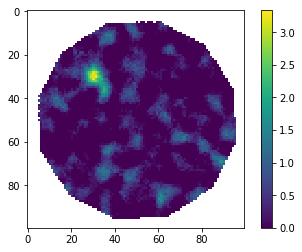

In [7]:
print(a,b)
img = b/np.sqrt(a)
plt.imshow(img)
plt.colorbar()
